<a href="https://colab.research.google.com/github/Yoshiven/Emotion_Detection/blob/main/Emotion_Detection_ResNet101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ananthu017/emotion-detection-fer

100% 65.0M/65.2M [00:04<00:00, 20.2MB/s]
100% 65.2M/65.2M [00:04<00:00, 15.4MB/s]


In [ ]:
! unzip emotion-detection-fer

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [ ]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

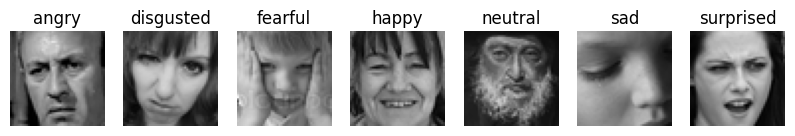

In [ ]:
index = 1
plt.figure(figsize=(10, 5))
for classname in classes:
    class_dir = os.path.join(train_dir, classname)

    for filename in os.listdir(class_dir)[:1]:
        image = cv.imread(os.path.join(class_dir, filename))

        plt.subplot(1, len(classes), index)
        plt.title(classname)
        plt.imshow(image, cmap="gray")
        plt.axis("off")

        index += 1

plt.show()

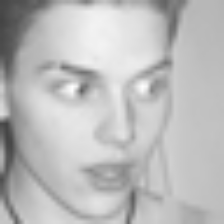

In [ ]:
images = []
image_classes = []
total_image_per_class = []

for classname in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, classname)

    for filename in os.listdir(class_dir):
        image = cv.imread(os.path.join(class_dir, filename))
        image = cv.resize(image, (224, 224))
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        images.append(image)
        image_classes.append(classname)

    total_image_per_class.append(len(os.listdir(class_dir)))

data = list(zip(images, image_classes))
len(data)
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=.2)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

In [ ]:
training_data = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  shuffle=True,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  subset='training',
                                                  seed=10)

validation_data = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    subset='validation',
                                                    seed=10)

testing_data = test_datagen.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                shuffle=False,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                # subset='training',
                                                seed=10)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
rn101 = ResNet101(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

171446536/171446536 [==============================] - 9s 0us/step


In [ ]:
headModel = rn101.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(classes), activation="softmax")(headModel)

In [ ]:
model = Model(inputs=rn101.input, outputs=headModel)

In [ ]:
for layer in rn101.layers:
  layer.trainable = False

In [ ]:
# compile model
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 395s 526ms/step - loss: 1.8735 - accuracy: 0.2211 - val_loss: 1.8077 - val_accuracy: 0.2513
Epoch 2/20
718/718 [==============================] - 366s 509ms/step - loss: 1.8358 - accuracy: 0.2436 - val_loss: 1.8125 - val_accuracy: 0.2513
Epoch 3/20
718/718 [==============================] - 359s 500ms/step - loss: 1.8378 - accuracy: 0.2513 - val_loss: 1.8116 - val_accuracy: 0.2512
Epoch 4/20
718/718 [==============================] - 359s 500ms/step - loss: 1.8352 - accuracy: 0.2511 - val_loss: 1.8110 - val_accuracy: 0.2513


In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

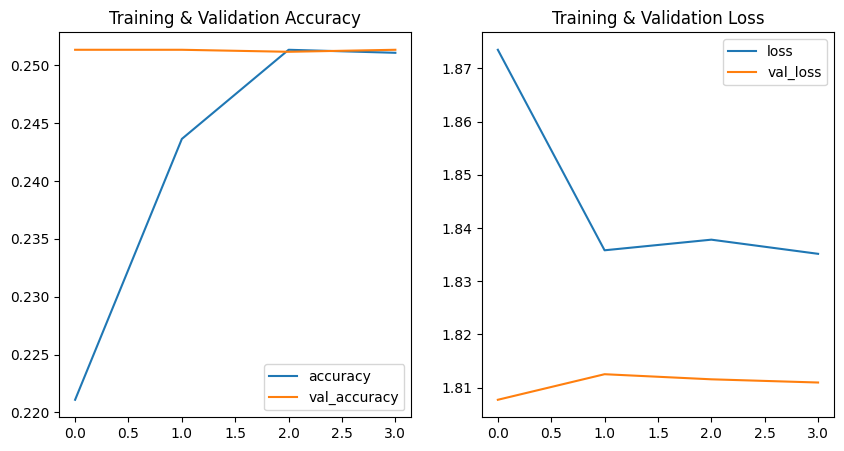

In [ ]:
visualize_history(history)

In [ ]:
model.evaluate(testing_data)

225/225 [==============================] - 89s 396ms/step - loss: 1.8137 - accuracy: 0.2471


[1.8136608600616455, 0.24714405834674835]

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 92s 403ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.25      1.00      0.40      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.24714405126776262
recall:  0.24714405126776262
precision:  0.06108869262212775
f1-score:  0.09796303138174749
Result =  0.16333495663485012


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for layer in rn101.layers:
	layer.trainable = True

In [ ]:
for layer in rn101.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7f6a00fbfe20>: True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f69ff2d0d90>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f69fca7f310>: True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f69ff1ce850>: True
<keras.layers.core.activation.Activation object at 0x7f69fca7fd90>: True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f69ff196ee0>: True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f69ff1b69d0>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f69ff1c0c70>: True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f69fdd62850>: True
<keras.layers.core.activation.Activation object at 0x7f69fdd60910>: True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f69fdd65d60>: True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f69fdd72af0>: True
<keras.layers.c

In [ ]:
# recompile model
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 562s 732ms/step - loss: 1.6644 - accuracy: 0.3935 - val_loss: 2.1308 - val_accuracy: 0.2132
Epoch 2/20
718/718 [==============================] - 524s 729ms/step - loss: 1.3159 - accuracy: 0.4956 - val_loss: 1.3547 - val_accuracy: 0.4809
Epoch 3/20
718/718 [==============================] - 521s 725ms/step - loss: 1.1961 - accuracy: 0.5468 - val_loss: 1.1575 - val_accuracy: 0.5557
Epoch 4/20
718/718 [==============================] - 521s 726ms/step - loss: 1.1265 - accuracy: 0.5722 - val_loss: 1.1201 - val_accuracy: 0.5800
Epoch 5/20
718/718 [==============================] - 520s 725ms/step - loss: 1.0542 - accuracy: 0.6006 - val_loss: 1.1155 - val_accuracy: 0.5774
Epoch 6/20
718/718 [==============================] - 521s 726ms/step - loss: 0.9987 - accuracy: 0.6219 - val_loss: 1.0683 - val_accuracy: 0.6009
Epoch 7/20
718/718 [==============================] - 523s 728ms/step - loss: 0.9605 - accuracy: 0.6350 - val_loss: 1.0440 -

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

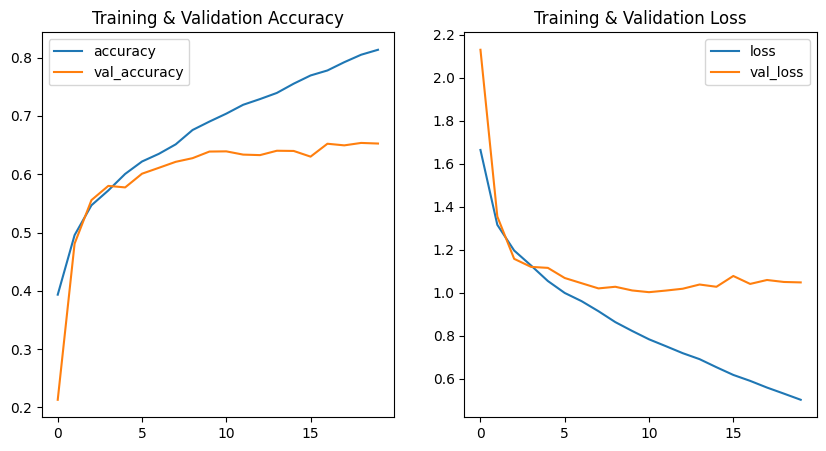

In [ ]:
visualize_history(history)

In [ ]:
model.evaluate(testing_data)

225/225 [==============================] - 89s 396ms/step - loss: 1.0780 - accuracy: 0.6535


[1.0779917240142822, 0.65352463722229]

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 91s 399ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57       958
           1       0.80      0.43      0.56       111
           2       0.51      0.42      0.46      1024
           3       0.85      0.86      0.85      1774
           4       0.59      0.62      0.61      1233
           5       0.51      0.54      0.53      1247
           6       0.77      0.76      0.76       831

    accuracy                           0.65      7178
   macro avg       0.65      0.60      0.62      7178
weighted avg       0.65      0.65      0.65      7178



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.647255502925606
recall:  0.647255502925606
precision:  0.6474679703647128
f1-score:  0.6454548353810884
Result =  0.6468584528992533
